In [36]:
import re
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

In [103]:
# === Baum import ===
start_tree_path = r"1762246214192778_out/1762246214192778_start_tree.newick"
final_tree_path = r"1762246214192778_out/1762246214192778_tree.newick"
# 1. Dateiinhalt einlesenS
file_path = '1762246214192778_out/1762246214192778.log'
log_content = ""

try:
    # NEU: explizitSe Angabe der Codierung (encoding='utf-8') zur Vermeidung des Decodierungsfehlers
    with open(file_path, 'r', encoding='utf-8') as f:
        log_content = f.read()
    print(f"Datei '{file_path}' erfolgreich und mit UTF-8 Codierung eingelesen.")
except FileNotFoundError:
    print(f"FEHLER: Die Datei '{file_path}' wurde nicht gefunden.")
    print("Bitte stellen Sie sicher, dass sich die Datei im selben Verzeichnis wie das Skript befindet oder passen Sie den Pfad an.")
    exit()
except Exception as e:
    # Falls UTF-8 fehlschlägt, ist oft 'latin-1' die letzte Rettung
    if 'UnicodeDecodeError' in str(e):
        try:
            with open(file_path, 'r', encoding='latin-1') as f:
                log_content = f.read()
            print(f"HINWEIS: UTF-8 schlug fehl, aber Datei '{file_path}' wurde erfolgreich mit LATIN-1 eingelesen.")
        except Exception as e_latin:
            print(f"SCHWERWIEGENDER FEHLER: Weder UTF-8 noch LATIN-1 konnten die Datei lesen: {e_latin}")
            exit()
    else:
        print(f"FEHLER beim Einlesen der Datei: {e}")
        exit()

Datei '1762246214192778_out/1762246214192778.log' erfolgreich und mit UTF-8 Codierung eingelesen.


In [104]:
# 2. Datenstrukturen initialisieren
model_iterations = []
model_costs = []
topo_steps = []
topo_costs = []
spr_counter = 0

In [105]:
# 3. Reguläre Ausdrücke definieren (wie zuvor)
# Haupt-ML-Optimierung (z.B. Branch Lengths Optimierung)
model_pattern = re.compile(r"phylo::optimisers::blen_optimiser\s+Iteration: (\d+), current cost: (-?\d+\.\d+)")

# Topologie-Optimierung (Initial und akzeptierte SPR Moves)
topo_initial_pattern = re.compile(r"phylo::optimisers::topo_optimiser Initial cost: (-?\d+\.\d+)")
topo_spr_pattern = re.compile(r"SPR move applied, new cost (-?\d+\.\d+)")

time_pattern = re.compile(r"^(\d{2}:\d{2}:\d{2})")

In [106]:
# --- Neue Muster für Sequenzanzahl und Alignment-Länge ---
seq_pattern = re.compile(
    r"(?:Loaded alignment with|Number of sequences:|Number of sequence\(s\):?)\s*(\d+)\s*(?:sequence\(s\)?|sequences?)?",
    re.IGNORECASE
)
align_pattern = re.compile(
    r"(?:and\s*)?(\d+)\s*(?:sites|positions|columns|bp|alignment length)",
    re.IGNORECASE
)

# --- Neue Variablen ---
sequence_number = None
alignment_length = None

In [107]:
# 4. Daten extrahieren (durchlaufen der Log-Datei)
start_time = None
end_time = None

for line in log_content.splitlines():
    # --- Modelloptimierung extrahieren ---
    match_model = model_pattern.search(line)
    if match_model:
        iteration = int(match_model.group(1))
        cost = float(match_model.group(2))
        model_iterations.append(iteration)
        model_costs.append(cost)

    # --- Sequence Number extrahieren ---
    if sequence_number is None:
        match_seq = seq_pattern.search(line)
        if match_seq:
            sequence_number = int(match_seq.group(1))

    # --- Alignment Length extrahieren ---
    if alignment_length is None:
        match_align = align_pattern.search(line)
        if match_align:
            alignment_length = int(match_align.group(1))

    # --- Topologieoptimierung extrahieren ---
    # Nur die erste Initial Cost speichern
    match_initial = topo_initial_pattern.search(line)
    if match_initial and not topo_costs: 
        cost = float(match_initial.group(1))
        topo_steps.append(spr_counter)
        topo_costs.append(cost)
        
    # Akzeptierte SPR Moves extrahieren
    match_spr = topo_spr_pattern.search(line)
    if match_spr:
        spr_counter += 1
        cost = float(match_spr.group(1))
        topo_steps.append(spr_counter)
        topo_costs.append(cost)

        # Start- und Endzeit erkennen
    if "JATI run started" in line:
        match = time_pattern.match(line)
        if match:
            start_time = datetime.strptime(match.group(1), "%H:%M:%S")
    elif "Final log-likelihood" in line:
        match = time_pattern.match(line)
        if match:
            end_time = datetime.strptime(match.group(1), "%H:%M:%S")

In [108]:
# === 5. Gesamtlaufzeit berechnen ===
total_runtime = None
if start_time and end_time:
    total_runtime = (end_time - start_time).total_seconds()
    print(f"Gesamtlaufzeit: {total_runtime:.1f} Sekunden ({total_runtime/60:.1f} Minuten)")
else:
    print("WARNUNG: Keine Start-/Endzeit im Log gefunden – Laufzeit kann nicht berechnet werden.")
    total_runtime = 1.0  # Fallback, um Division durch Null zu vermeiden

Gesamtlaufzeit: 114.0 Sekunden (1.9 Minuten)


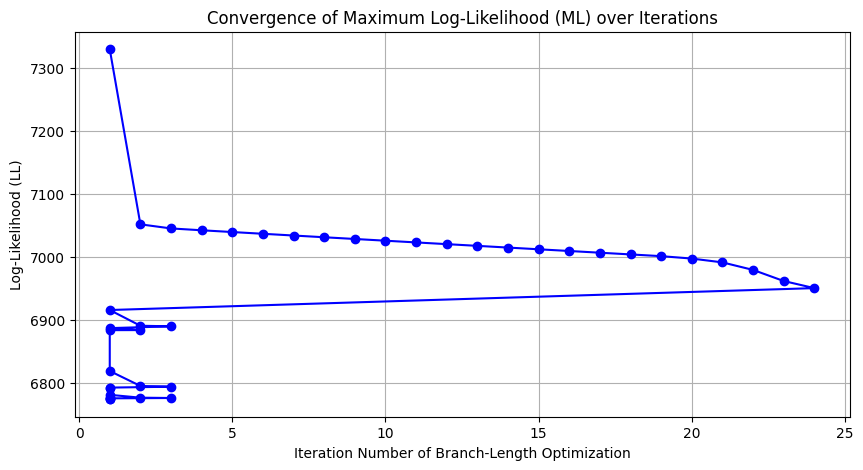

In [109]:
# 5. Plot the data

# The cost is the Negative Log-Likelihood (-LL). 
# We plot the Log-Likelihood (LL = -(-LL)), which should be maximized.

# Plot 1: Convergence of the ML Parameter Optimization (Branch Lengths/Model)
if model_costs:
    plt.figure(figsize=(10, 5))
    # Conversion from -LL to LL
    plt.plot(model_iterations, -np.array(model_costs), marker='o', linestyle='-', color='blue')
    plt.title('Convergence of Maximum Log-Likelihood (ML) over Iterations')
    plt.xlabel('Iteration Number of Branch-Length Optimization')
    plt.ylabel('Log-Likelihood (LL)')
    plt.grid(True)
    plt.show() # The image is displayed here

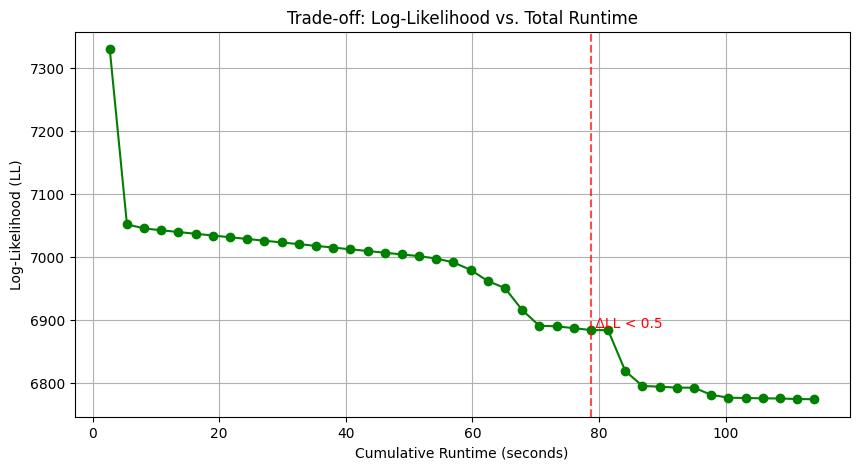

In [110]:
# === 6. Gleichmäßige Verteilung der Zeit auf Iterationen ===
if model_iterations and total_runtime > 0:
    iteration_times = np.full(len(model_iterations), total_runtime / len(model_iterations))
    cumulative_time = np.cumsum(iteration_times)

    # === 7. Plot: Log-Likelihood vs. Total Runtime ===
    plt.figure(figsize=(10, 5))
    ll_values = -np.array(model_costs)
    plt.plot(cumulative_time, ll_values, marker='o', linestyle='-', color='green')
    plt.title('Trade-off: Log-Likelihood vs. Total Runtime')
    plt.xlabel('Cumulative Runtime (seconds)')
    plt.ylabel('Log-Likelihood (LL)')
    plt.grid(True)

    # === Variante A: Stoppschwelle basierend auf ΔLL (epsilon) ===
    epsilon = 0.5  # entspricht deinem Optimierungsparameter
    deltas = np.abs(np.diff(ll_values))

    # Finde die erste Iteration, bei der sich LL kaum noch ändert
    idx_good = np.argmax(deltas < epsilon)

    # Falls keine Änderung kleiner als epsilon gefunden wurde -> letzte Iteration nehmen
    if idx_good == 0 and deltas[0] >= epsilon:
        idx_good = len(deltas) - 1

    # Rote Linie an der Stelle zeichnen, wo "Konvergenz" erreicht wurde
    plt.axvline(cumulative_time[idx_good], color='red', linestyle='--', alpha=0.7)
    plt.text(cumulative_time[idx_good], ll_values[idx_good],
             f' ΔLL < {epsilon}', color='red', va='bottom')

    plt.show()

else:
    print("Keine Modelldaten zum Plotten gefunden.")


In [111]:
# 6. Ergebnisse zusammenfassen (Optional)
if model_costs and topo_costs:
    print(f"\n--- Zusammenfassung ---")
    print(f"Finaler Log-Likelihood (ML) Wert nach Parameter-Optimierung: {-model_costs[-1]:.4f}")
    # print(f"Finaler Log-Likelihood (ML) Wert nach Topologie-Optimierung: {-topo_costs[-1]:.4f}")


--- Zusammenfassung ---
Finaler Log-Likelihood (ML) Wert nach Parameter-Optimierung: 6774.2026


In [112]:
from Bio import AlignIO
from io import StringIO

alignment_path = "C:/A.Fächer/5. Semester/A. Project 2/benchmark-datasets/benchmark-datasets/aa/medium/boroa6_OG303_gene354.fasta"
# Versuch mit UTF-8, wenn das fehlschlägt -> Latin-1
try:
    with open(alignment_path, 'r', encoding='utf-8') as f:
        content = f.read()
except UnicodeDecodeError:
    with open(alignment_path, 'r', encoding='latin-1') as f:
        content = f.read()

# Inhalt an AlignIO übergeben
alignment = AlignIO.read(StringIO(content), "fasta")

sequence_number = len(alignment)
alignment_length = alignment.get_alignment_length()

print(f"Anzahl der Sequenzen: {sequence_number}")
print(f"Alignment-Länge: {alignment_length}")

Anzahl der Sequenzen: 33
Alignment-Länge: 408


In [113]:
from Bio import Phylo
from io import StringIO
from Bio.Phylo.TreeConstruction import _Matrix
from itertools import combinations

def robinson_foulds(tree1, tree2):
    """
    Berechnet die (nicht-normalisierte und normalisierte) RF-Distanz zwischen zwei Bäumen.
    """
    # Extrahiere Splits (Clades)
    def get_splits(tree):
        terminals = tree.get_terminals()
        n = len(terminals)
        splits = set()
        for clade in tree.find_clades(order='postorder'):
            if clade.is_terminal():
                continue
            split = frozenset([t.name for t in clade.get_terminals()])
            if 0 < len(split) < n:
                splits.add(split)
        return splits

    splits1 = get_splits(tree1)
    splits2 = get_splits(tree2)

    rf_distance = len(splits1.symmetric_difference(splits2))
    max_splits = len(splits1) + len(splits2)
    normalized_rf = rf_distance / max_splits if max_splits > 0 else 0

    return rf_distance, normalized_rf


# === Datei-Pfade anpassen ===
# start_tree_path = r"C:/A.Fächer/5. Semester/A. Project 2/Results/dna_easy/0.0001/1761851998086079_out/1761851998086079_start_tree.newick"
# final_tree_path = r"C:/A.Fächer/5. Semester/A. Project 2/Results/dna_easy/0.0001/1761851998086079_out/1761851998086079_tree.newick"

# === Einlesen der Newick-Bäume ===
try:
    tree1 = Phylo.read(start_tree_path, "newick")
    tree2 = Phylo.read(final_tree_path, "newick")
except Exception as e:
    print(f"Fehler beim Einlesen der Bäume: {e}")
    exit()

# === RF-Distanz berechnen ===
rf_distance, normalized_rf = robinson_foulds(tree1, tree2)

print("\n--- RF Distance ---")
print(f"Robinson–Foulds Distance: {rf_distance}")
print(f"Normalized RF Distance: {normalized_rf:.4f}")

# === Optional: Tree-Infos ===
print(f"\nAnzahl Taxa in Baum 1: {len(tree1.get_terminals())}")
print(f"Anzahl Taxa in Baum 2: {len(tree2.get_terminals())}")



--- RF Distance ---
Robinson–Foulds Distance: 78
Normalized RF Distance: 0.7959

Anzahl Taxa in Baum 1: 51
Anzahl Taxa in Baum 2: 51
